# I want my GAN produce vectors of 100 entries containing first 50 zeros and last 50 non-zeros

In [345]:
import torch
import matplotlib.pyplot as plt

# Dataset Prep

In [346]:
mask = torch.linspace(-5, 5, 100)>.5

In [347]:
step = torch.ones(100)

In [348]:
step[mask==False] = 0.

In [349]:
step

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [350]:
rand = torch.randn(100, 100)

In [351]:
X = rand*step

In [352]:
X = torch.ones(100, 100)-.5 - torch.randn(100, 100)*.01

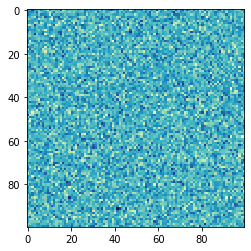

In [353]:
plt.imshow(X, cmap='YlGnBu', interpolation='nearest')

In [354]:
X

tensor([[0.5084, 0.5033, 0.5276,  ..., 0.4898, 0.5108, 0.5068],
        [0.5139, 0.5108, 0.5105,  ..., 0.4995, 0.4899, 0.5075],
        [0.5160, 0.5075, 0.5011,  ..., 0.4965, 0.4977, 0.4933],
        ...,
        [0.5033, 0.4909, 0.4918,  ..., 0.5029, 0.4920, 0.5166],
        [0.4868, 0.4903, 0.4994,  ..., 0.5038, 0.5069, 0.4948],
        [0.5025, 0.5054, 0.5033,  ..., 0.5060, 0.5052, 0.5045]])

# Dataset class

In [355]:
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    
    def __init__(self, x):
        self.x = x
        
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

In [356]:
dataset = MyCustomDataset(X)

# DataLoader

In [357]:
from torch.utils.data import DataLoader

batch_size = len(dataset)

train_loader = DataLoader(dataset, batch_size, shuffle=True)

# Discriminator

In [358]:
class Discriminator(torch.nn.Module):
  def __init__(self, input_size):
    super(Discriminator, self).__init__()
    self.disc = torch.nn.Sequential(
        torch.nn.Linear(input_size, int(input_size/2.)),
        torch.nn.Sigmoid(),
        torch.nn.Linear(int(input_size/2.), 1),
        torch.nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.disc(x)

In [359]:
modelD = Discriminator(100)

# Generator

In [360]:
class Generator(torch.nn.Module):
  def __init__(self, z_dim, img_dim):
    super(Generator, self).__init__()
    self.gen = torch.nn.Sequential(
        torch.nn.Linear(z_dim, 50),
        torch.nn.Sigmoid(),
        torch.nn.Linear(50, img_dim),
        torch.nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.gen(x)

In [361]:
modelG = Generator(15, 100)

In [362]:
z_dim = 15

In [363]:
fixed_noise = torch.randn((100, z_dim))

In [364]:
optimizerD = torch.optim.Adam(modelD.parameters(), lr=.00001)
optimizerG = torch.optim.Adam(modelG.parameters(), lr=.00001)
criterion = torch.nn.BCELoss()

In [365]:
LOSSES_D = []
LOSSES_G = []
for epoch in range(3000):
  for real in train_loader:
    noise = torch.randn(batch_size, z_dim)
    fake = modelG(noise)

    disc_real = modelD(real)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = modelD(fake)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real+lossD_fake)/2.
    optimizerD.zero_grad()
    lossD.backward(retain_graph=True)
    optimizerD.step()
    LOSSES_D.append(lossD.item())


    disc_fake = modelD(fake)
    loss = criterion(disc_fake, torch.ones_like(disc_fake))
    optimizerG.zero_grad()
    loss.backward()
    optimizerG.step()
    LOSSES_G.append(loss.item())

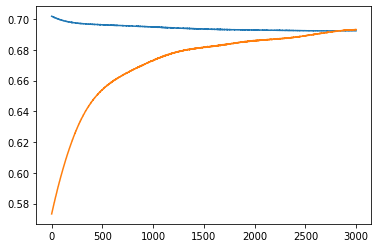

In [366]:
import matplotlib.pyplot as plt
plt.plot(LOSSES_D)
plt.plot(LOSSES_G)

In [367]:
nn = torch.ones(15)-.5
with torch.no_grad():
  y = modelG(fixed_noise)

In [368]:
y

tensor([[0.4285, 0.4170, 0.4881,  ..., 0.4115, 0.5124, 0.5395],
        [0.4405, 0.4057, 0.4780,  ..., 0.4189, 0.4711, 0.5332],
        [0.4210, 0.4171, 0.4737,  ..., 0.4036, 0.4555, 0.5192],
        ...,
        [0.4221, 0.4341, 0.5029,  ..., 0.4415, 0.5190, 0.5321],
        [0.4055, 0.4079, 0.5246,  ..., 0.4346, 0.4974, 0.5225],
        [0.4321, 0.4143, 0.4722,  ..., 0.3998, 0.4859, 0.5386]])

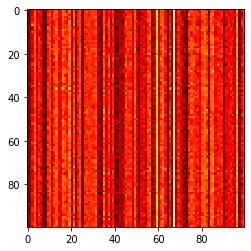

In [369]:
plt.imshow(y, cmap='hot', interpolation='nearest')